# The Basics of TOAD

TOAD's core functionality is exposed through the `TOAD` class, which analyzes netCDF files or xarray datasets. The two primary methods - `compute_shifts` and `compute_clusters` - handle the main analysis steps. Additional helper functions and visualization tools make it easy to explore and understand the results.

**The following tutorial will guide you through the basic workflow of TOAD (Viel Spaß! 🎉):**

In [ ]:
# 1. Uncomment this line to install the library in editable mode, if not already installed
# %pip install -e ..

# 2. After installation, restart notebook

In [1]:
# Prerequisites
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Include this once we have a published release to fetch test data
# from toad.utils import download_test_data
# download_test_data()

test_data directory already exists at /Users/jakobharteg/GitHub/toad/tutorials/test_data


## 1.0—Init the TOAD object

Init toad object with an xarray or .nc file


In [2]:
from toad import TOAD, TOADPlotter

# Init the TOAD object with an xarray or .nc file
# td = TOAD("data/my_dataset.nc")

# Or load file with pre-computed shifts
data = xr.open_dataset("test_data/garbe_2020_antarctica.nc").coarsen(x=2, y=2, time=2, boundary='trim').mean() # lower resolution to speed up cluster computation

# init TOAD object
td = TOAD(data, time_dim="time") # if your time/forcing dimension is NOT called "time", please pass it in here. 

In [3]:
# The TOAD object wraps the xarray datasets and provides analysis functions etc.
# You can always access the underlying xarray dataset with td.data
# Note that this file already have shifts computed for variable "thk", called "thk_dts".
td.data

<xarray.Dataset> Size: 13MB
Dimensions:  (time: 175, y: 95, x: 95)
Coordinates:
  * time     (time) float64 1kB 501.0 1.301e+03 ... 1.389e+05 1.397e+05
  * x        (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * y        (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
    lat      (y, x) float64 72kB -52.13 -52.5 -52.87 ... -53.06 -52.69 -52.32
    lon      (y, x) float64 72kB -135.0 -135.6 -136.2 ... 43.75 44.38 45.0
Data variables:
    thk      (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_dts  (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institution:    PIK / Potsdam Institute for Climate Impact Research
    author:         Julius Garbe (julius.garbe@pik-potsdam.de)
    ...             ...
    title:          Antarctic ice thickness evolution for the quasi-static re...
    Conventions:    CF-1.9
    projection:     Polar Stereographic South (71S,0E)
    ice_density:    910. kg m-3
    NCO:            netCDF Operators version 4.7.8 (Homepage = http://nco.sf....
    Modifications:  Modified by Jakob Harteg (jakob.harteg@pik-potsdam.de) No...

## 1.1 — Preprocessing
Run preprocessing checks:
- Nothing implemented yet...

In [4]:
# td.preprocess()...

## 1.2 — Compute shifts
Computing shifts means running the algorithm that detects how fast the time series in each variable changes, but TOAD will allow for a broader range of methods

Under the hood, TOAD creates a new variable in the data frame called `{var}_dts` for a variable called `{var}`

In [5]:
from toad.shifts_detection.methods import ASDETECT


# Minimum required input is a variable name and method
td.compute_shifts("thk", method=ASDETECT())

# All options:
# shifts = td.compute_shifts(
#     var="thk",
#     method=ASDETECT(        # default method
#         lmin=5,             # minimum length of segments
#         lmax=None,          # maximum length of segments
#     ),
#     time_dim="time",    # time dimension
#     output_label="my_shifts", # changes the name of the new variable
#     return_results_directly=True, # if you don't want to merge the result with the original 
# )

You can write your own shifts detection methods by subclassing the base class in `toad.shifts_detection.methods.base`. See the example `examples/shifts_detection_methods.ipynb` for more info.

## 1.3—Compute clusters

In [6]:
from sklearn.cluster import HDBSCAN


# Minimum required input is a variable name, a method and a filtering function. 
td.compute_clusters(
    var='thk',                                  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=25),        
    shifts_filter_func=lambda x: np.abs(x)>0.8, # toad will cluster the points that pass this filter
)

# # All options:
# clusters = td.compute_clusters(
#     var='thk',    
#     method=HDBSCAN( # HDBSCAN also has various params
#         min_cluster_size=10,
#         min_samples=None,                
#         cluster_selection_epsilon=0.0,   
#         metric="euclidean",              
#     ),
#     shifts_label="thk_dts", # if you had named your shifts variable differently, pass it in here
#     shifts_filter_func=lambda x: np.abs(x)>0.8,
#     var_filter_func=lambda x: x > 1,
#     output_label="my_clusters",
#     return_results_directly=True, # if you don't want to merge the result with the original 
# );

You can write your own clustering methods by subclassing the base class in `sklearn.cluster.base`. See the example [clustering_methods.ipynb](../tutorials/clustering_methods.ipynb) for more info.

## 1.4 — Postprocessing

By default, results from shifts and cluster computations are merged into the original dataset (td.data). While you can access everything directly, TOAD provides helper functions to easily extract insights from the results.

In [7]:
td.data

<xarray.Dataset> Size: 25MB
Dimensions:      (time: 175, y: 95, x: 95)
Coordinates:
  * time         (time) float64 1kB 501.0 1.301e+03 ... 1.389e+05 1.397e+05
  * x            (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * y            (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
    lat          (y, x) float64 72kB -52.13 -52.5 -52.87 ... -52.69 -52.32
    lon          (y, x) float64 72kB -135.0 -135.6 -136.2 ... 43.75 44.38 45.0
Data variables:
    thk          (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_dts      (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_cluster  (time, y, x) int64 13MB -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institution:    PIK / Potsdam Institute for Climate Impact Research
    author:         Julius Garbe (julius.garbe@pik-potsdam.de)
    ...             ...
    title:          Antarctic ice thickness evolution for the quasi-static re...
    Conventions:    CF-1.9
    projection:     Polar Stereographic South (71S,0E)
    ice_density:    910. kg m-3
    NCO:            netCDF Operators version 4.7.8 (Homepage = http://nco.sf....
    Modifications:  Modified by Jakob Harteg (jakob.harteg@pik-potsdam.de) No...

In [8]:
# Easily get shifts and clusters
shifts = td.get_shifts("thk")
clusters = td.get_clusters("thk")

In [9]:
# Get a list of identified clusters sorted by number of cells in each cluster
# -1 = unclustered cells
td.get_cluster_counts('thk')

{-1: 1535550,
 0: 19376,
 1: 8078,
 2: 7321,
 3: 2998,
 4: 1911,
 5: 734,
 6: 634,
 7: 448,
 8: 353,
 9: 314,
 10: 287,
 11: 233,
 12: 201,
 13: 190,
 14: 173,
 15: 145,
 16: 109,
 17: 80,
 18: 49,
 19: 44,
 20: 39,
 21: 39,
 22: 38,
 23: 31}

In [10]:
# short hand for getting just the ids of the (sorted) clusters
td.get_cluster_ids('thk')

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23])

In [11]:
# Parameters used for shift computation are saved as attrs
td.get_shifts("thk").attrs  # or directly td.data.thk_dts.attrs

{'temporal_dim': 'time',
 'method': 'ASDETECT',
 'method_param_lmin': '5',
 'method_param_lmax': '',
 'git_version': '0.2'}

In [12]:
# Parameters used for clustering computation are saved as attrs
td.get_clusters("thk").attrs # or directly td.data.thk_cluster.attrs

{'cluster_ids': array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23]),
 'var_filter_func': 'None',
 'shifts_filter_func': '    shifts_filter_func=lambda x: np.abs(x)>0.8, # toad will cluster the points that pass this filter\n',
 'scaler': 'StandardScaler',
 'method_name': 'HDBSCAN',
 'method_algorithm': 'auto',
 'method_allow_single_cluster': 'False',
 'method_alpha': '1.0',
 'method_cluster_selection_epsilon': '0.0',
 'method_cluster_selection_method': 'eom',
 'method_copy': 'False',
 'method_leaf_size': '40',
 'method_metric': 'euclidean',
 'method_min_cluster_size': '25',
 'toad_version': '0.3'}

In [13]:
# Get a mask for all cells in a cluster
cluster_mask = td.get_cluster_mask("thk", cluster_id=6)
td.data.where(cluster_mask)

# Or a shorthand for this is
data = td.get_cluster_data("thk", cluster_id=6)
data

<xarray.Dataset> Size: 25MB
Dimensions:      (time: 175, y: 95, x: 95)
Coordinates:
  * time         (time) float64 1kB 501.0 1.301e+03 ... 1.389e+05 1.397e+05
  * x            (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * y            (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
    lat          (y, x) float64 72kB -52.13 -52.5 -52.87 ... -52.69 -52.32
    lon          (y, x) float64 72kB -135.0 -135.6 -136.2 ... 43.75 44.38 45.0
Data variables:
    thk          (time, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    thk_dts      (time, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    thk_cluster  (time, y, x) float64 13MB nan nan nan nan ... nan nan nan nan
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institution:    PIK / Potsdam Institute for Climate Impact Research
    author:         Julius Garbe (julius.garbe@pik-potsdam.de)
    ...             ...
    title:          Antarctic ice thickness evolution for the quasi-static re...
    Conventions:    CF-1.9
    projection:     Polar Stereographic South (71S,0E)
    ice_density:    910. kg m-3
    NCO:            netCDF Operators version 4.7.8 (Homepage = http://nco.sf....
    Modifications:  Modified by Jakob Harteg (jakob.harteg@pik-potsdam.de) No...

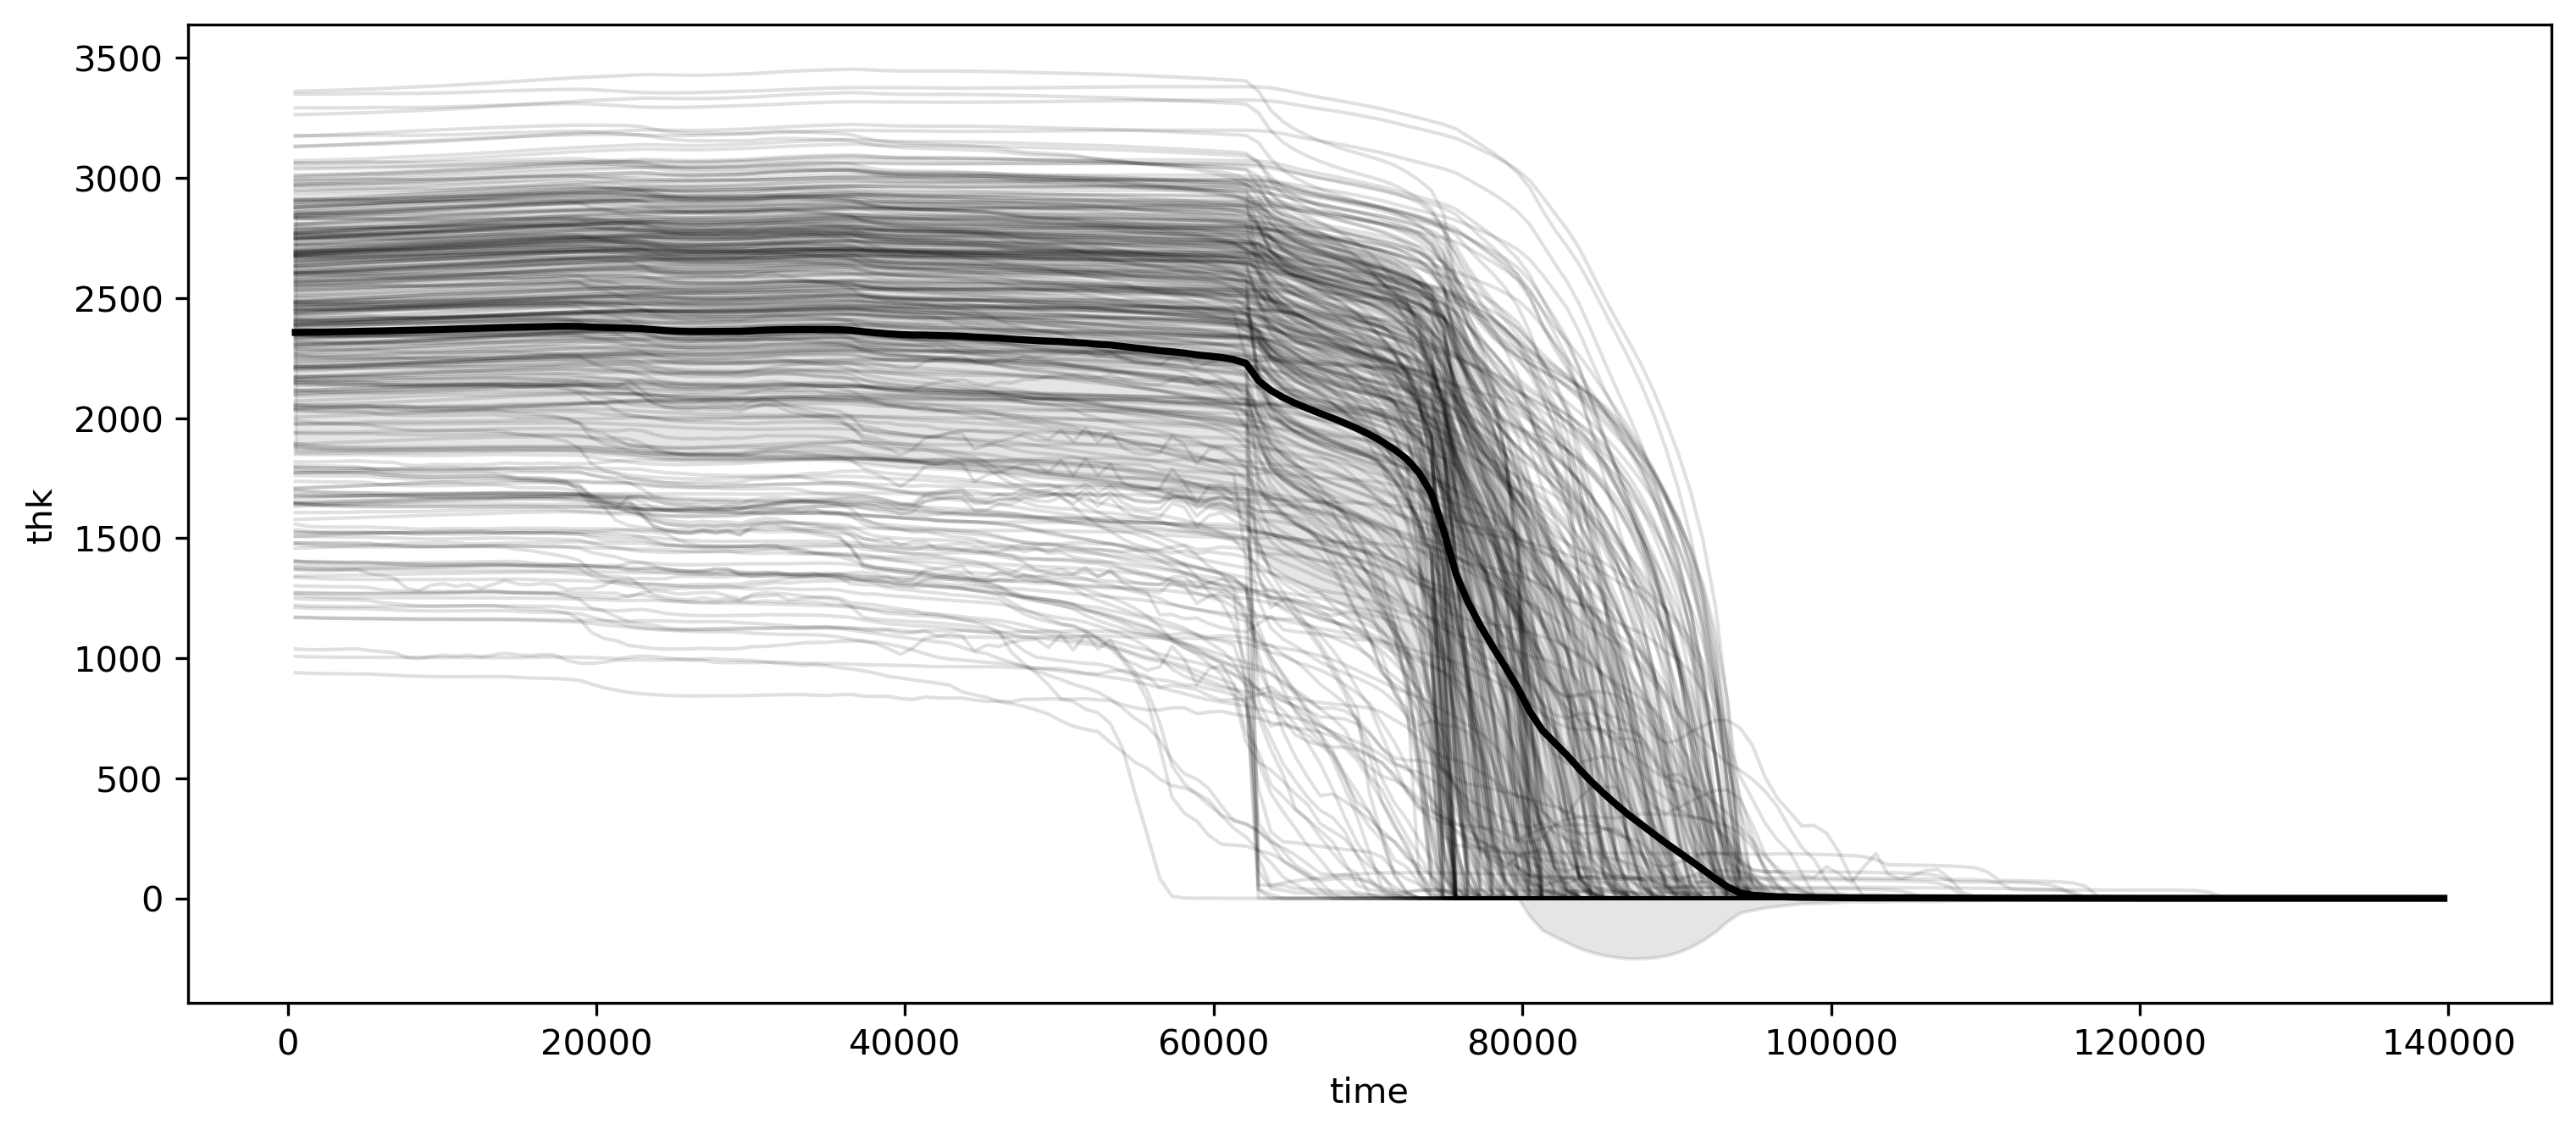

In [15]:
# Get time series from clusters
timeseries = td.get_cluster_timeseries("thk", cluster_id=2)
timeseries_mean = td.get_cluster_timeseries("thk", cluster_id=2, aggregation="mean")
timeseries_std = td.get_cluster_timeseries("thk", cluster_id=2, aggregation="std")

for ts in timeseries:
    ts.plot(color="k", alpha=0.12, lw=1)

timeseries_mean.plot(color="k", lw=2)
plt.fill_between(timeseries_mean.time, timeseries_mean - timeseries_std, timeseries_mean + timeseries_std, color='k', alpha=0.1)

### 1.4.1—Stats
Calling `td.cluster_stats(var)` and the submodules `time` and `space` will expose more statistics related helper functions.

In [16]:
# get start time for cluster 5
start_time = td.cluster_stats("thk").time.start(5)

# prints
print("Cluster 5 starts at", start_time)
print("\n All time stats for cluster 5:")

# get all stats in dictionary
td.cluster_stats("thk").time.all_stats(5)

Cluster 5 starts at 9301.0

 All time stats for cluster 5:


{'duration': 32800.0,
 'end': 42101.0,
 'iqr_50': (16501.0, 29301.0),
 'iqr_90': (11701.0, 36501.0),
 'mean': 22711.35422343324,
 'median': 21301.0,
 'peak': 16501.0,
 'peak_density': 0.0033240997229916896,
 'start': 9301.0,
 'std': 7883.2213525689685}

In [17]:
# Get mean x,y position of cluster 5
mean_xy = td.cluster_stats("thk").space.mean_xy(5)

# prints
print("Mean xy:", mean_xy)
print("\n All space stats for cluster 5:")

td.cluster_stats("thk").space.all_stats(5)

Mean xy: (1999891.0081743868, 768283.378746594)

 All space stats for cluster 5:


{'footprint_mean_xy': (2016228.5714285714, 761828.5714285715),
 'footprint_median_xy': (2040000.0, 760000.0),
 'footprint_std_xy': (174492.09326569756, 123803.87386375868),
 'mean_xy': (1999891.0081743868, 768283.378746594),
 'median_xy': (2040000.0, 760000.0),
 'std_xy': (178469.14600900974, 116369.82446175563)}

In [18]:
# compute a rough cluster score giving a value close to 1 if the mean cluster time series resembles a heavy-side function. 
td.cluster_stats("thk").general.compute_cluster_score(6)

0.3159056769489921

## 1.5 — Plotting
**(In dev: These functions are very likely to change in the future)**

The `TOADPlotter` class provides a few simple plotting functions.

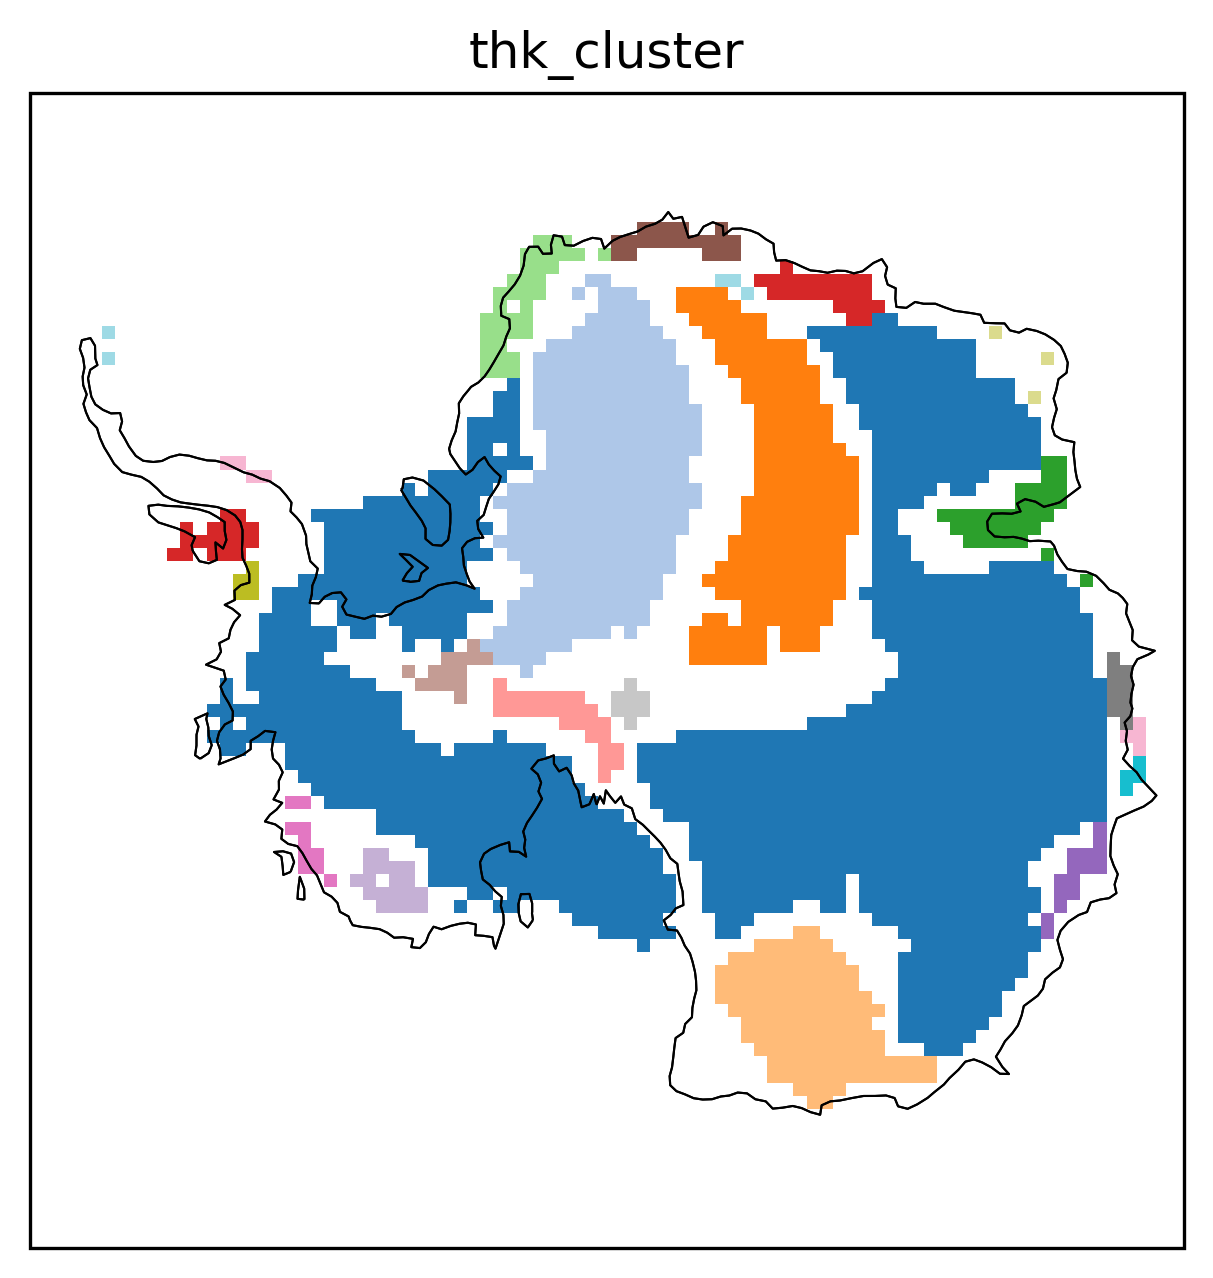

In [19]:
fig, ax = td.plotter().south_pole_plots(grid_labels=False)
TOADPlotter(td).plot_clusters_on_map("thk", ax=ax);

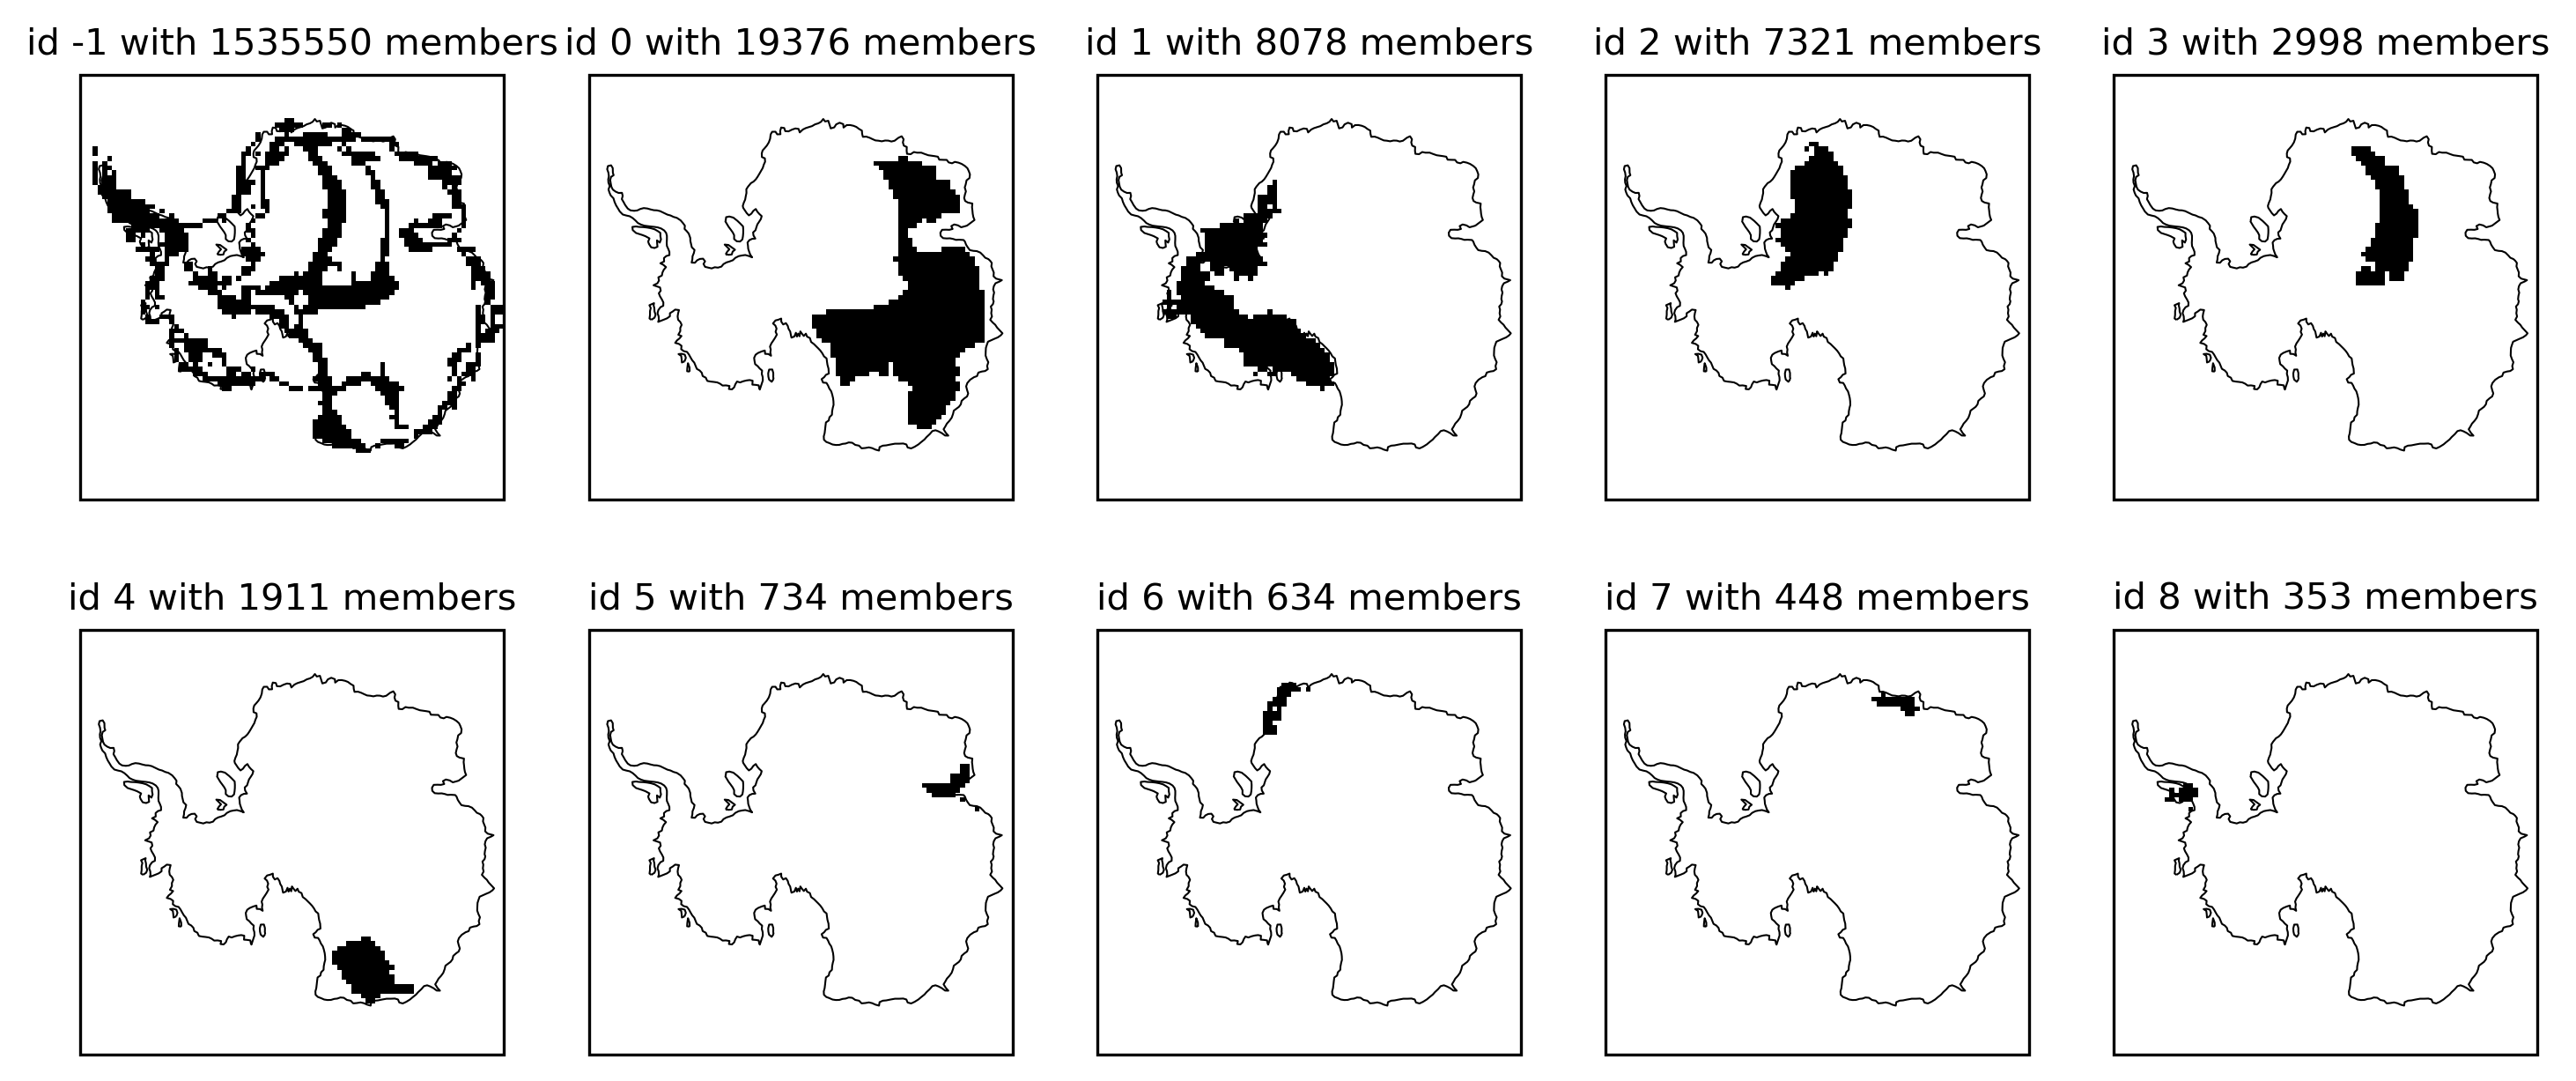

In [20]:
TOADPlotter(td).plot_clusters_on_maps('thk', max_clusters=10, south_pole=True)

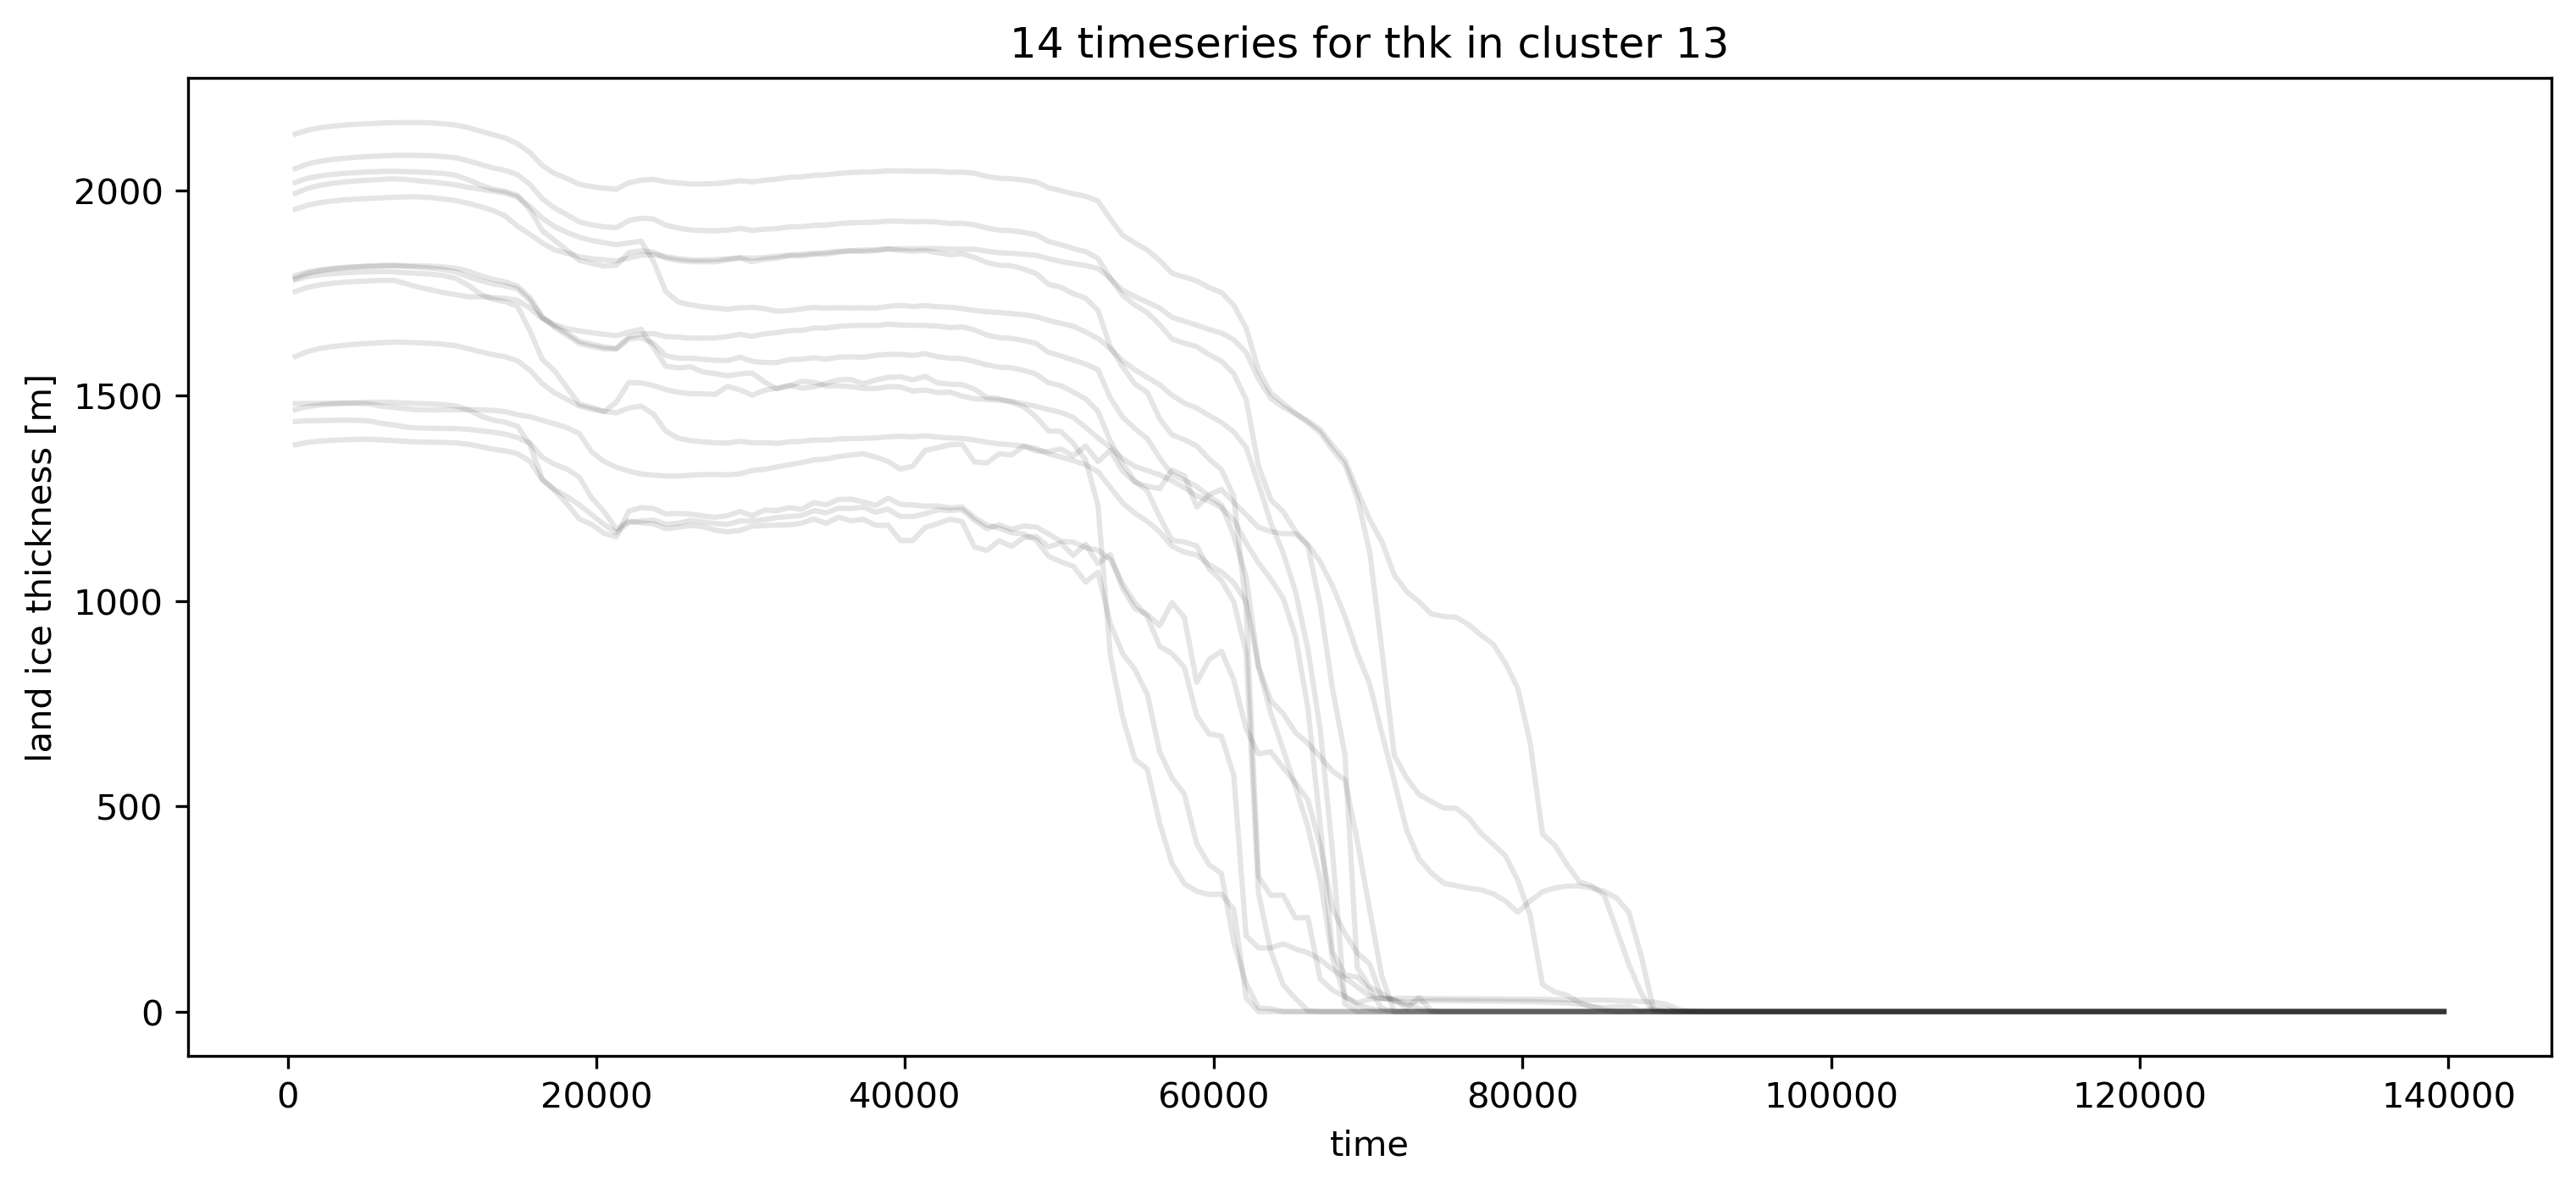

In [21]:
TOADPlotter(td).plot_cluster_time_series("thk", 13, color="black", alpha=0.1);

Text(0.5, 1.0, '100 timeseries from each of the 5 largest clusters')

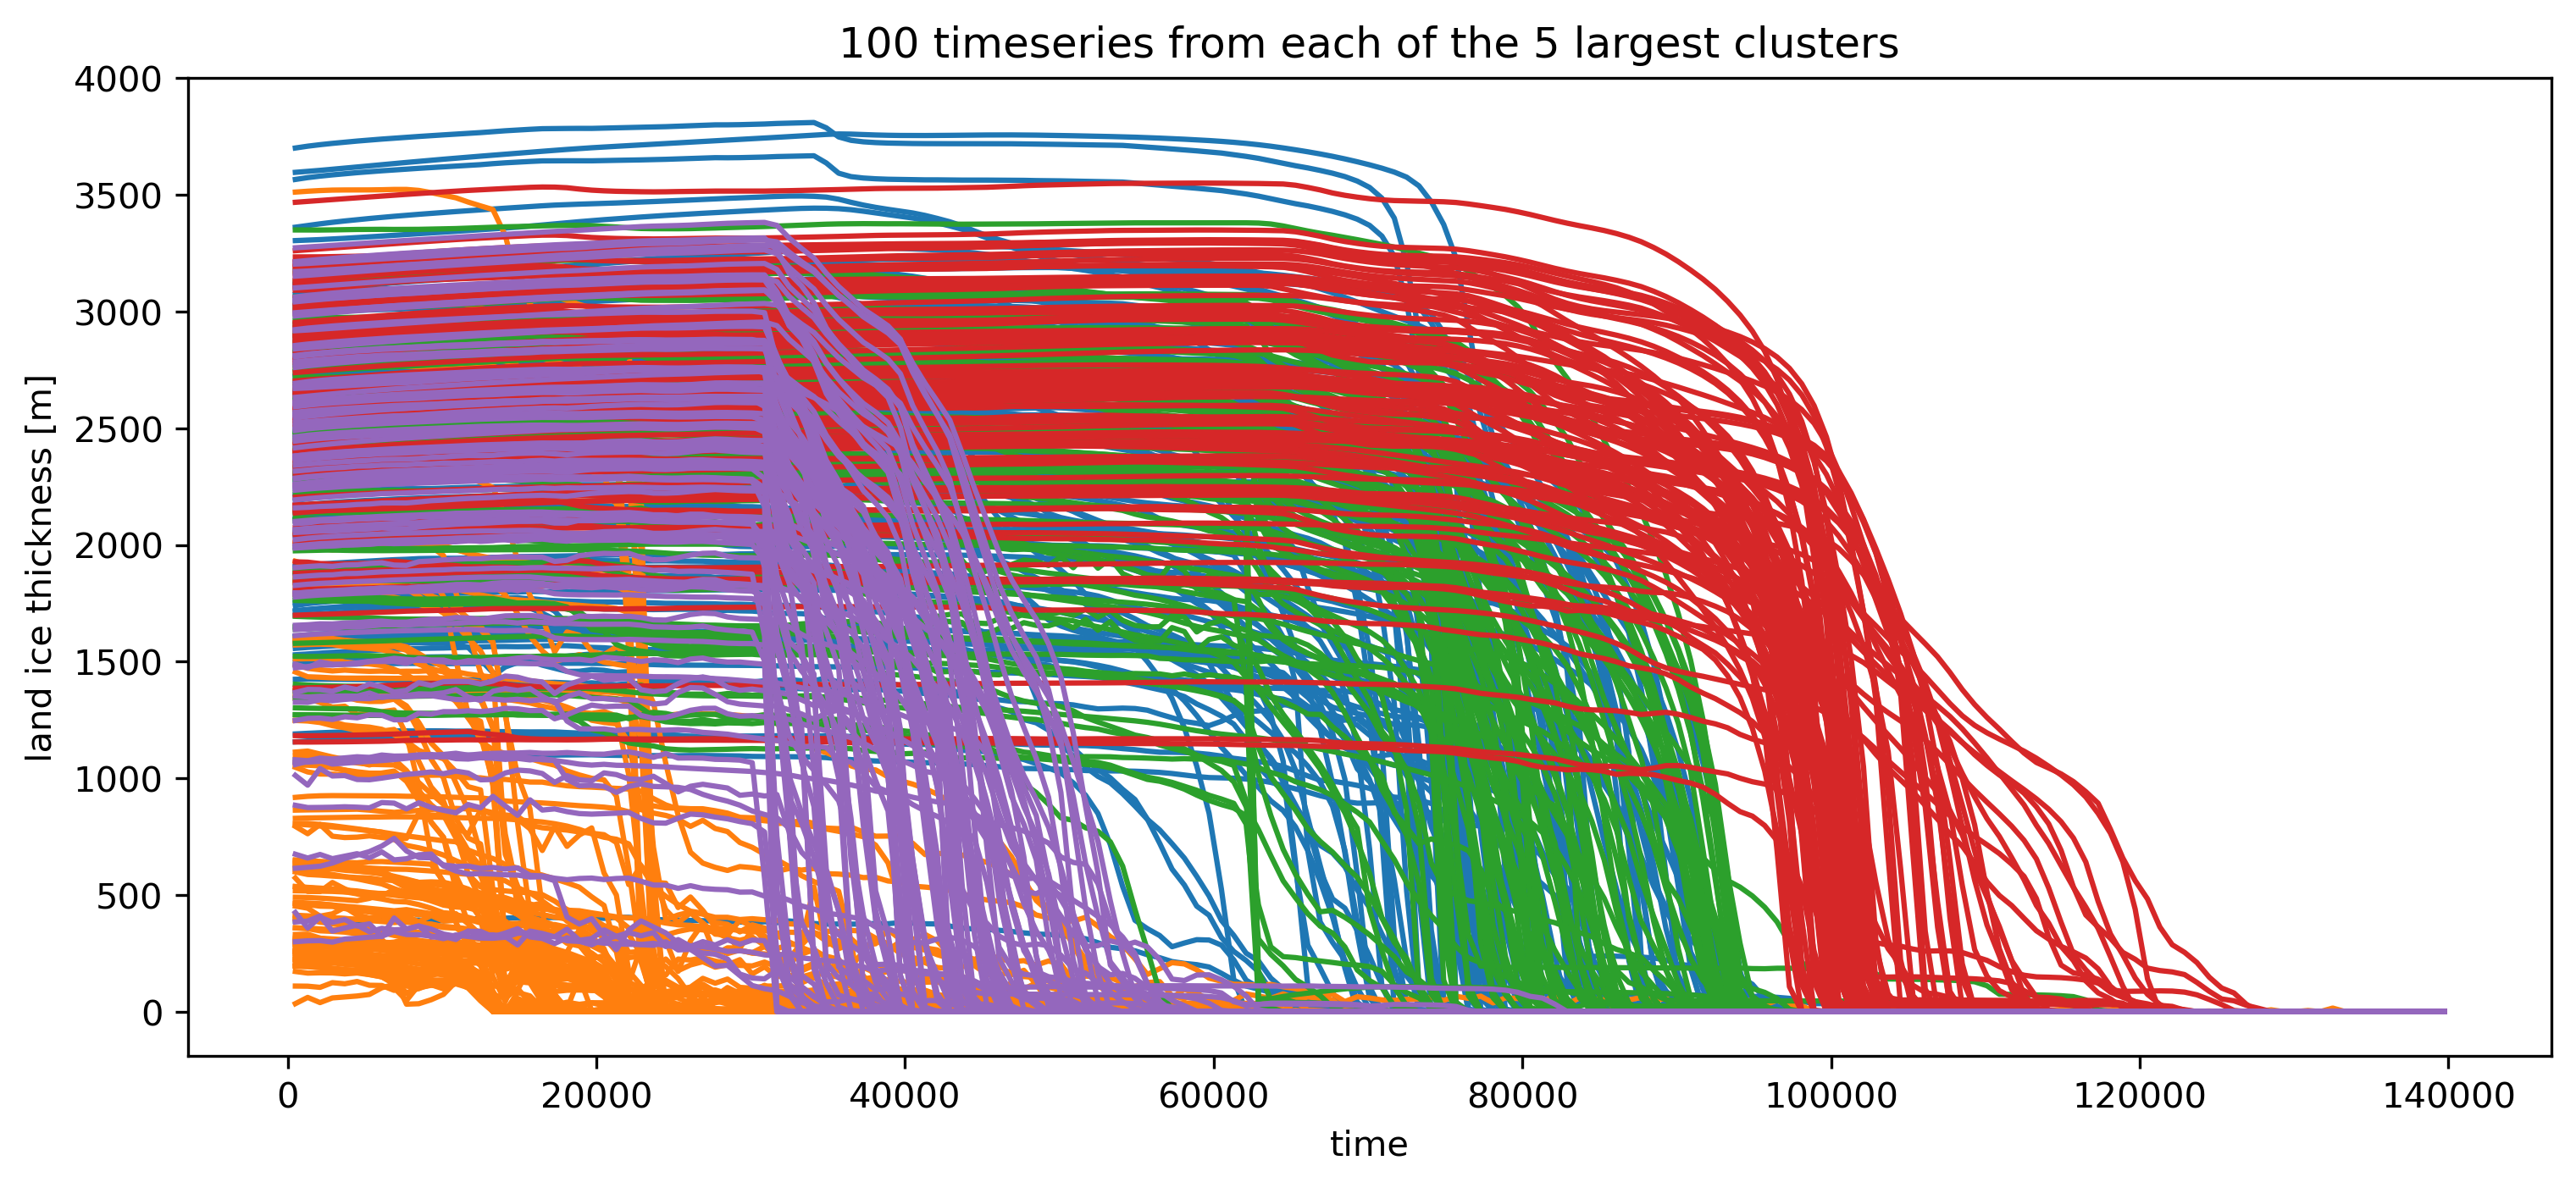

In [22]:
fig, ax = plt.subplots()
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i, id in enumerate(td.get_cluster_ids('thk')[1:6]): # skip -1 (unclustered cells)
    TOADPlotter(td).plot_cluster_time_series("thk", id, color=colors[i], max_trajectories=100, ax=ax);
ax.set_title("100 timeseries from each of the 5 largest clusters")

Text(0.5, 1.0, 'Mean ± std for [8, 12, 5, 2, 14]')

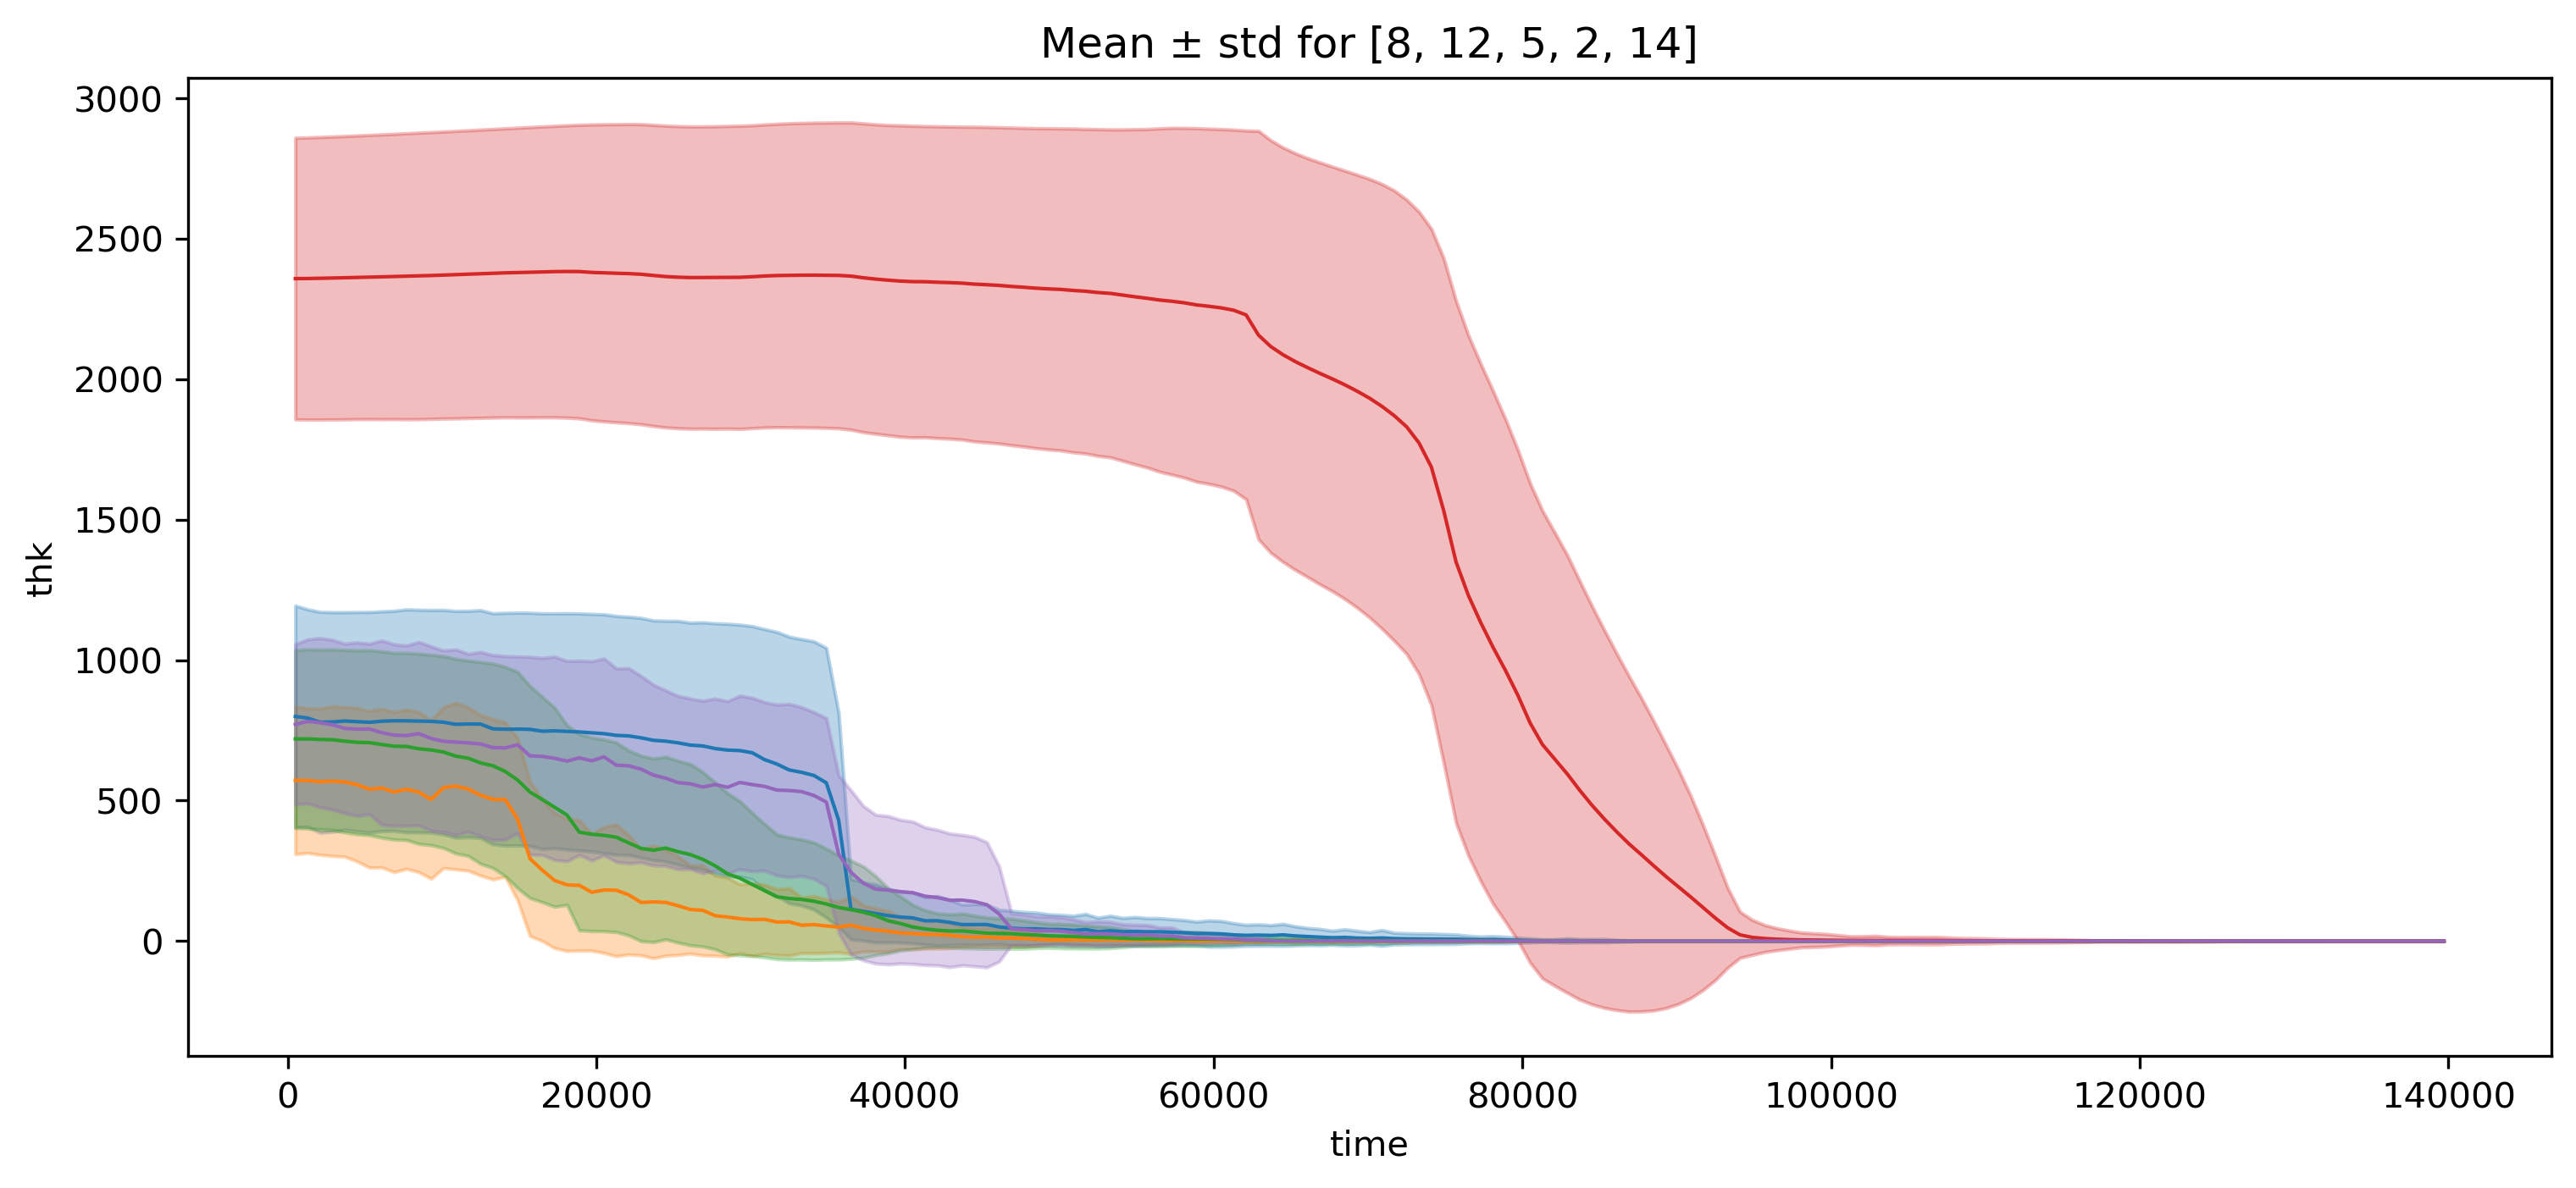

In [23]:
fig, ax = plt.subplots()
colors = plt.cm.tab10(np.linspace(0, 1, 10))
cluster_ids = [8, 12, 5, 2, 14]
for i, id in enumerate(cluster_ids):
    mean = td.get_cluster_timeseries("thk", id, aggregation="mean")
    std = td.get_cluster_timeseries("thk", id, aggregation="std")
    mean.plot(ax=ax, color=colors[i], lw=1)
    ax.fill_between(td.data.time, mean-std, mean+std, color=colors[i], alpha=0.3)
ax.set_title(f"Mean ± std for {cluster_ids}")

## Example 2
Let's just try some different data: Mean summer near-surface air temperature

In [26]:
# Dataset contains pre-computed shifts
data = xr.load_dataset("test_data/global_mean_summer_tas.nc")

# To test computing shifts, we can lower the resolution
data = data.coarsen(lat=2, lon=2, boundary='trim').mean()

td = TOAD(data)
# td.data

In [34]:
from toad.shifts_detection.methods import ASDETECT

td.compute_shifts("tas", method=ASDETECT()) 
# for coarsen(lat=7, lon=7) this takes 12 seconds on my laptop

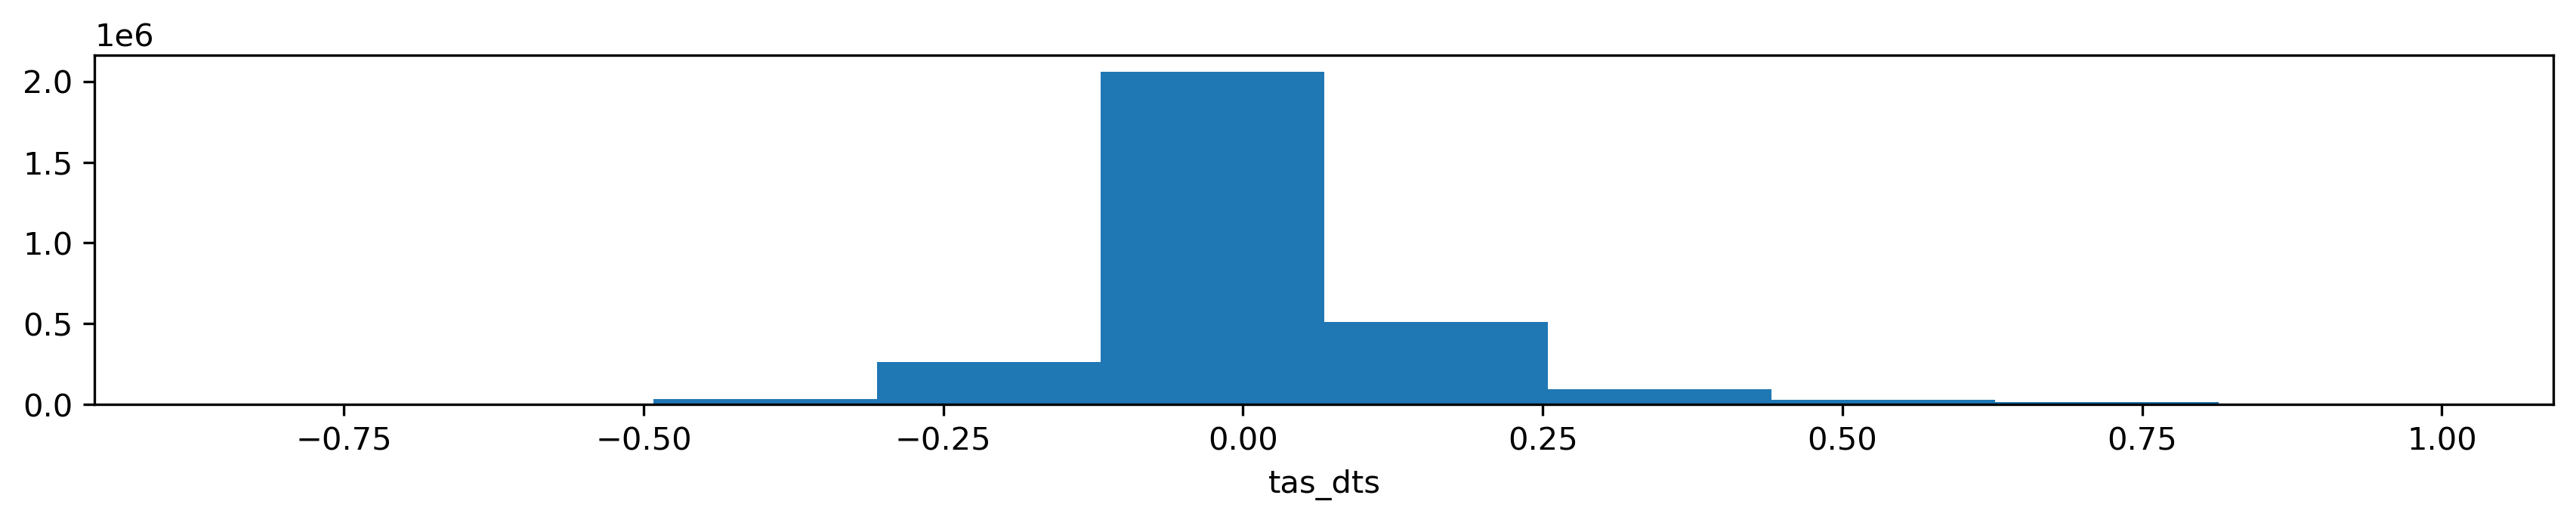

In [35]:
# Let's look at the shifts
td.get_shifts("tas").plot(figsize=(14,2));

In [36]:
from sklearn.cluster import HDBSCAN

td.compute_clusters("tas", shifts_filter_func=lambda x: np.abs(x)>0.5, method=HDBSCAN(min_cluster_size=40), overwrite=True)

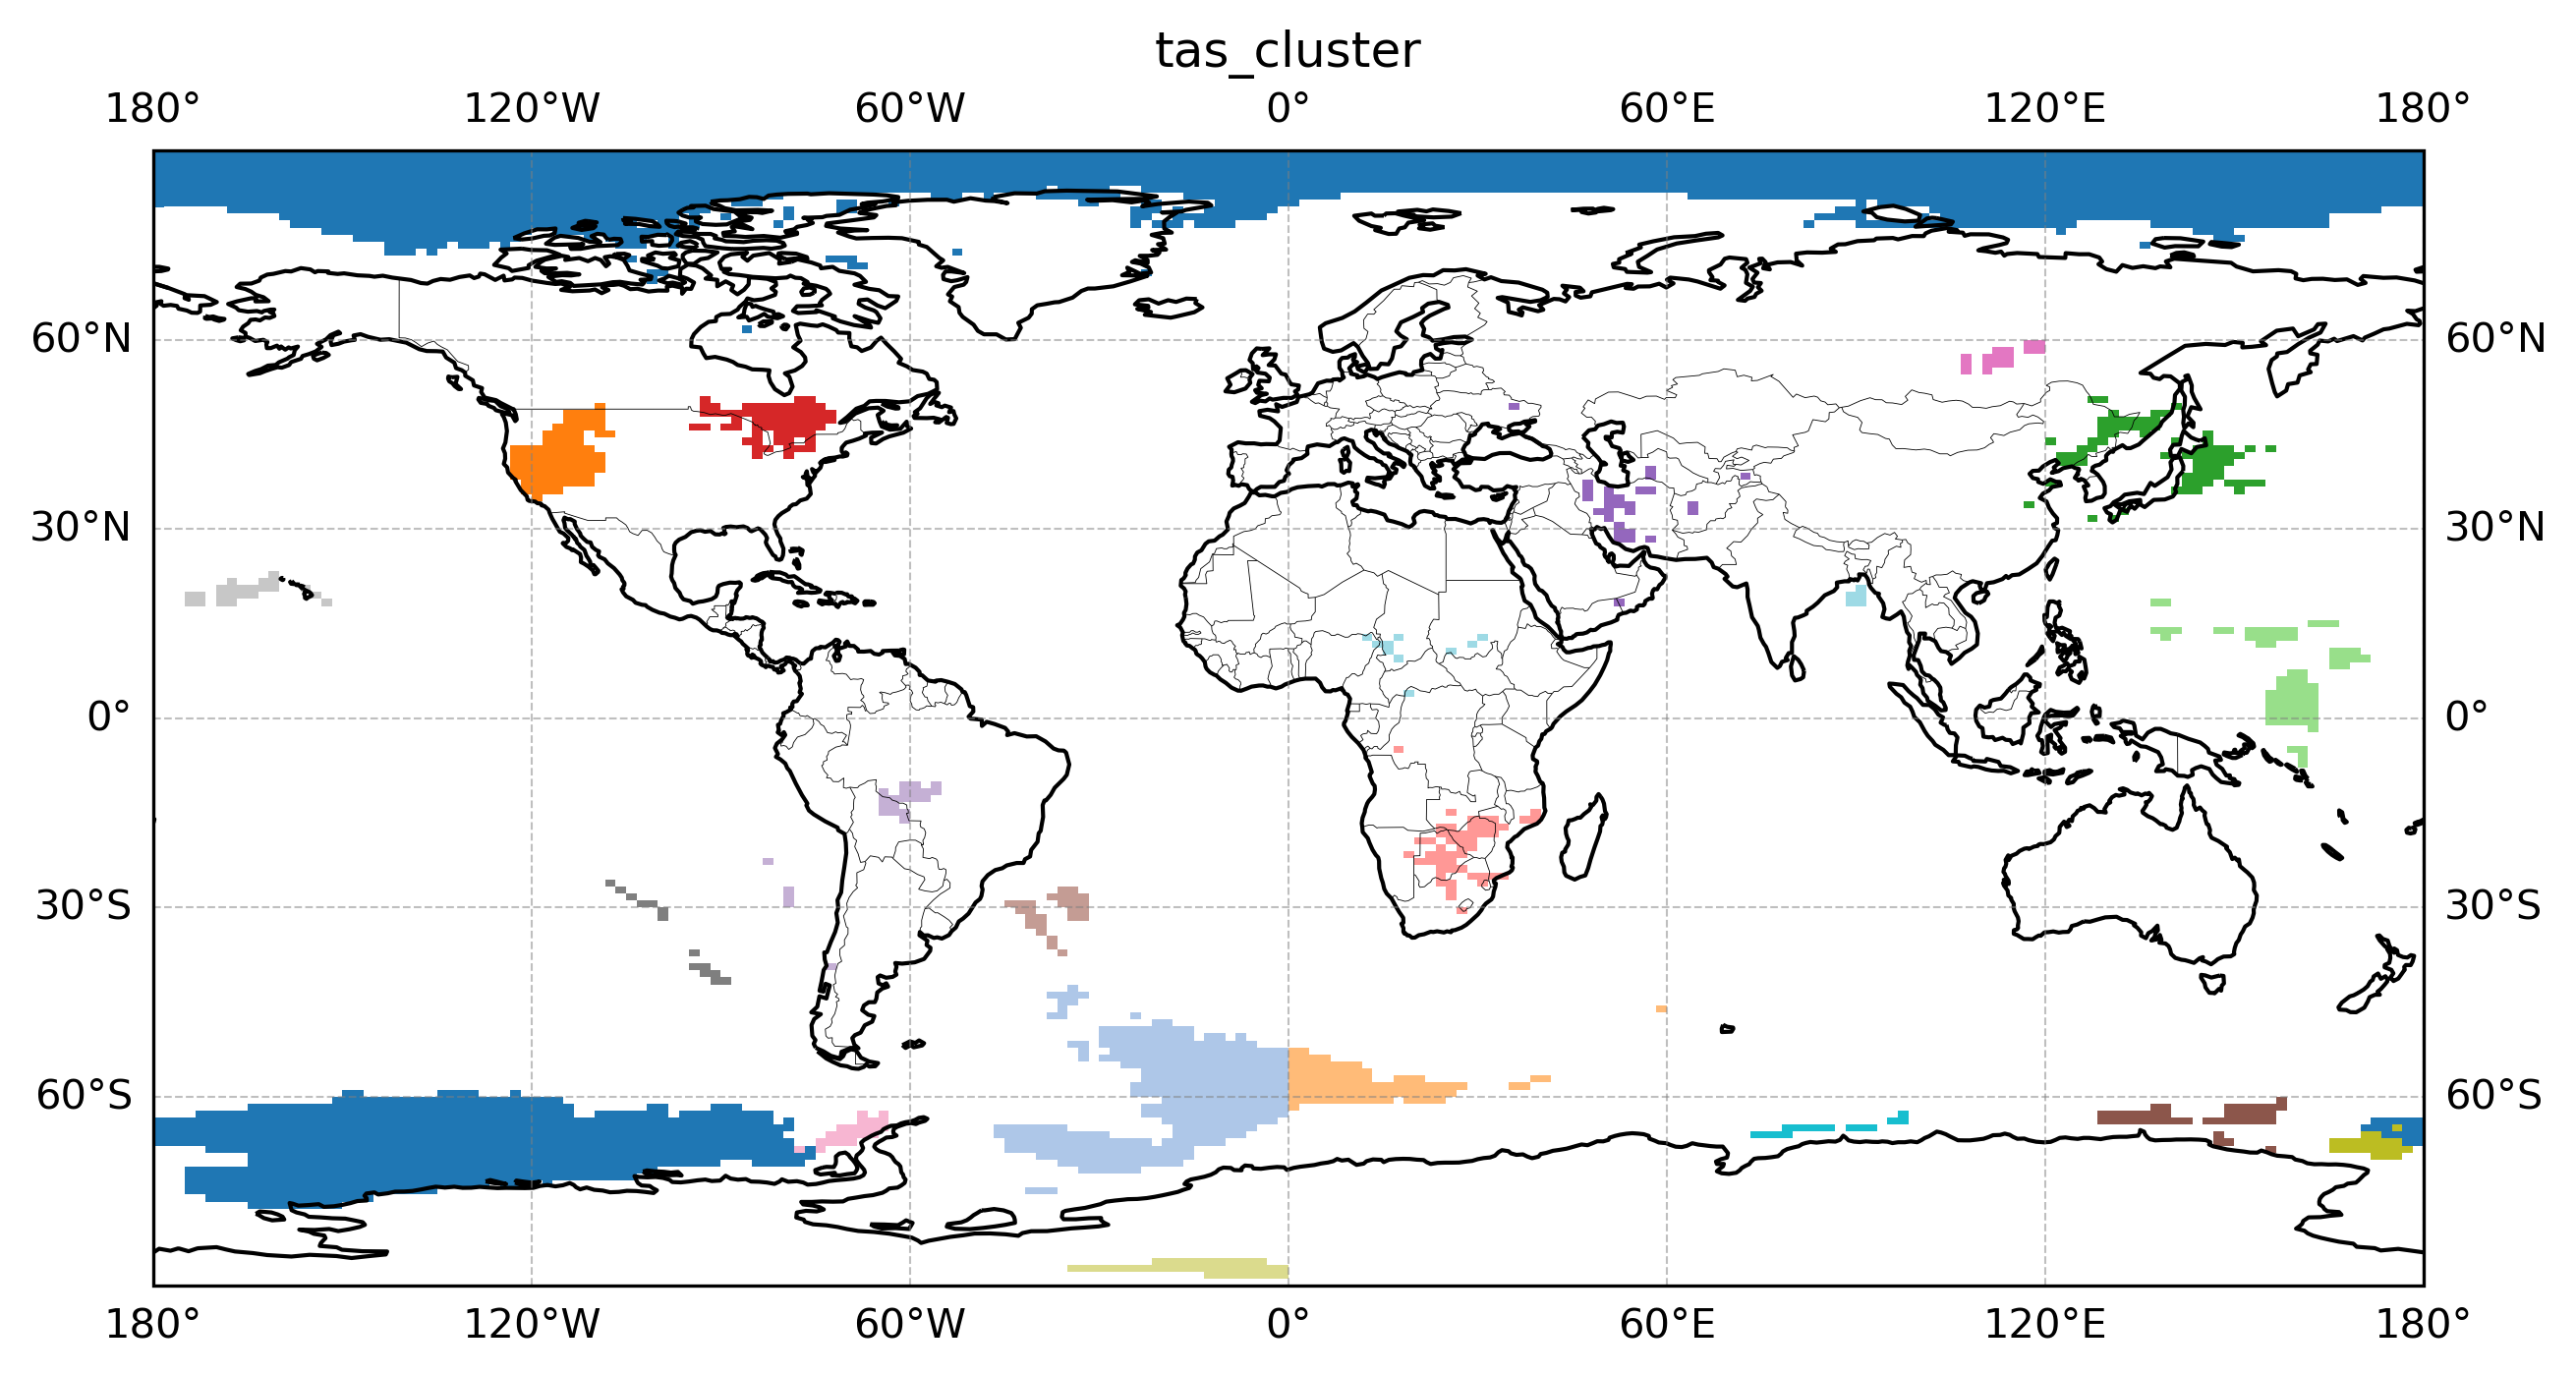

In [37]:
fig, ax = TOADPlotter(td).map_plots(linewidth=(1,.2))
TOADPlotter(td).plot_clusters_on_map("tas", ax=ax);

Here you see a current issue in clustering: HDBSCAN/DBSCAN uses euclidean distances, so clusters can't cross the 0° longitude line.